# **Rent Price Prediction: Model Training and Evaluation**

This notebook focuses on building and evaluating machine learning models to predict rent prices using a variety of techniques, including traditional regression models, ensemble methods, deep learning, and transformer-based models. The goal is to accurately predict rent prices based on property attributes, spatial data, and other engineered features. Key stages include data preprocessing, feature engineering, model training, and evaluation. The notebook also incorporates model stacking, deep neural networks, and tabular transformers for improved predictions. SHAP (SHapley Additive exPlanations) is used for model interpretability and feature importance analysis.

---

### **Table of Contents**

1. **Data Loading and Preprocessing**
   - Load the training and test datasets.
   - Preprocess the data (log-transforming, handling missing values, etc.).

2. **Modeling with Machine Learning**
   - Training different machine learning models (e.g., Decision Tree, Random Forest, XGBoost, Lasso, Ridge).
   - Evaluating model performance using RMSE and R² metrics.
   - Plotting actual vs. predicted values.

3. **Stacking Regressor**
   - Combining multiple models (Extra Trees, SVR, XGBoost) with Linear Regression as the meta-learner.
   - Evaluating the stacked model performance.

4. **Deep Learning: Neural Network**
   - Designing and training a deep neural network (DNN) for rent price prediction.
   - Monitoring performance and implementing early stopping.

5. **Tabular Transformer Model**
   - Implementing a transformer-based model for structured data.
   - Training and evaluation of the Tab Transformer.

6. **SHAP for Explainability**
   - Using SHAP to explain the model's predictions and assess feature importance.
   - Visualizing SHAP summary plots for better interpretability.

---

This structure guides the end-to-end process of predicting rent prices using various machine learning techniques and deep learning architectures while maintaining model interpretability with SHAP.

## **1. Data Loading and Preprocessing**

In [ ]:
! pip install shap
! pip install xgboost

In [38]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
import pickle

import shap
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge


In [39]:
X_train = pd.read_csv("../data/input/X_train.csv")
X_test = pd.read_csv("../data/input/X_test.csv")
y_train = pd.read_csv("../data/input/y_train.csv")
y_test =pd.read_csv("../data/input/y_test.csv")

In [40]:
print(X_test.shape)
print(X_train.shape)

(3691, 90)
(8611, 90)


## **2. Modeling with Machine Learning**

In this section, various machine learning models are trained and evaluated to predict rent prices based on the preprocessed dataset. The models include traditional regressors and ensemble methods, each of which brings unique strengths in handling the dataset’s complexity.

### **Models Used**:
- **Decision Tree Regressor**: A tree-based model that splits the data into subsets to capture non-linear relationships.
- **Extra Trees Regressor**: An ensemble model that improves upon decision trees by averaging multiple unpruned decision trees.
- **Random Forest Regressor**: Another ensemble method that builds multiple decision trees and averages their predictions for greater stability.
- **AdaBoost Regressor**: A boosting method that combines weak learners to create a strong model by focusing on difficult data points.
- **Gradient Boosting Regressor**: A boosting technique that builds models sequentially, each correcting the errors of the previous model.
- **XGBoost Regressor**: A highly efficient implementation of gradient boosting with regularization to prevent overfitting.
- **Lasso Regression**: A linear model with L1 regularization that shrinks less important feature coefficients to zero.
- **Ridge Regression**: A linear model with L2 regularization that helps to reduce the complexity of the model and prevent overfitting.

### **Evaluation Metrics**:
- **Root Mean Squared Error (RMSE)**: Measures the average error between predicted and actual rent prices, with a focus on large errors.
- **R² Score**: Represents the proportion of variance in the rent prices that the model is able to explain.

### **Visualisation**:
For each model, predicted vs. actual rent prices are plotted along with the ideal fit line (y = x) to visually assess model performance. This helps to identify how well the models predict rent prices across different ranges.

By comparing these models, the goal is to identify the most accurate and robust machine learning model for rent price prediction.

In [41]:
def evaluate_and_plot(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Inverse the log-transformation to get the original scale
    y_test_pred = np.expm1(y_test_pred)
    y_train_pred = np.expm1(y_train_pred)
    y_test = np.expm1(y_test)
    y_train = np.expm1(y_train)

    # Calculate RMSE and R^2 scores
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the performance metrics
    print(f"{model_name}:")
    print(f"  Training RMSE: {train_rmse:.2f}, R^2: {train_r2:.2f}")
    print(f"  Test RMSE: {test_rmse:.2f}, R^2: {test_r2:.2f}")

    # Plot predicted vs actual values with light yellow points and no border
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='#6753BF', label='Predicted vs Actual')  # light yellow color
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Ideal Fit (y = x)')
    
    plt.xlabel('Actual Values', fontsize=14, weight='bold')
    plt.ylabel('Predicted Values', fontsize=14, weight='bold')
    plt.title(f'Actual vs Predicted Values for {model_name}', fontsize=16, weight='bold', color='navy')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f"../plots/{model_name}_performance.png")
    plt.show()


In [42]:
models = [
    # Decision Tree Regressor: A tree-based model that splits data based on feature thresholds
    (DecisionTreeRegressor(), "Decision Tree Regressor"),
    
    # Extra Trees Regressor: An ensemble model that builds multiple unpruned decision trees using random samples of data
    (ExtraTreesRegressor(), "Extra Trees Regressor"),
    
    # Random Forest Regressor: An ensemble model that builds multiple decision trees and averages their predictions
    (RandomForestRegressor(), "Random Forest Regressor"),
    
    # AdaBoost Regressor: A boosting model that combines weak learners to form a stronger predictor, focusing on hard-to-predict instances
    (AdaBoostRegressor(), "AdaBoost Regressor"),
    
    # Gradient Boosting Regressor: A sequential boosting technique that builds models to correct errors made by previous models
    (GradientBoostingRegressor(), "Gradient Boosting Regressor"),
    
    # XGBoost Regressor: An efficient gradient boosting implementation with regularization to control overfitting
    (XGBRegressor(objective='reg:squarederror', n_estimators=120, learning_rate=0.15, max_depth=5, random_state=42), "XGBoost Regressor"),
    
    # Lasso Regression: A linear model with L1 regularization, which penalizes large coefficients and enforces sparsity (i.e., reduces less important feature coefficients to zero)
    (Lasso(alpha=0.00001), "Lasso Regression"),
    
    # Ridge Regression: A linear model with L2 regularization, which penalizes the size of coefficients to prevent overfitting
    (Ridge(alpha=0.7), "Ridge Regression")
]

Decision Tree Regressor:
  Training RMSE: 0.08, R^2: 1.00
  Test RMSE: 111.60, R^2: 0.41


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


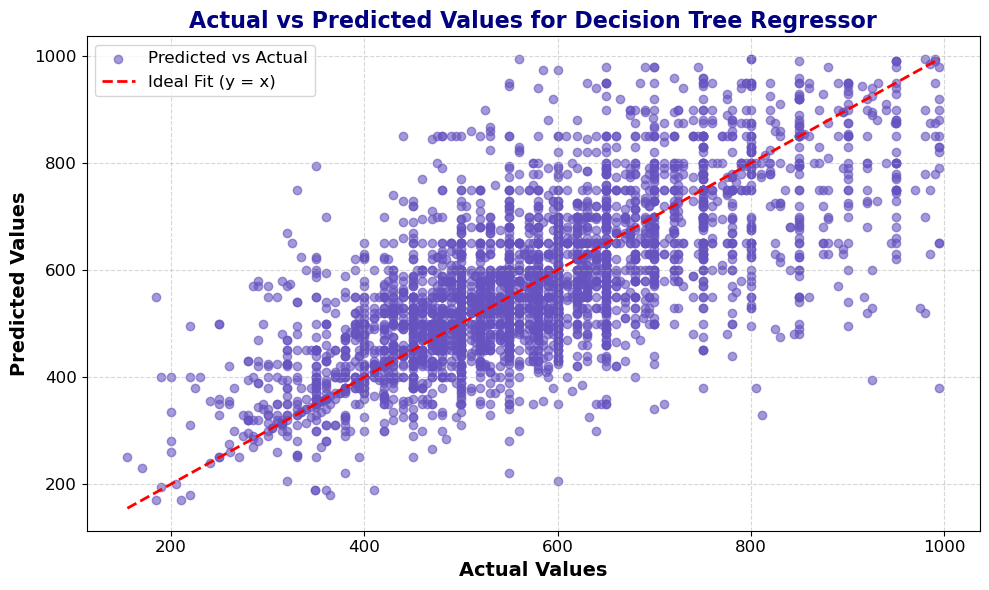

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Extra Trees Regressor:
  Training RMSE: 0.08, R^2: 1.00
  Test RMSE: 76.39, R^2: 0.73


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


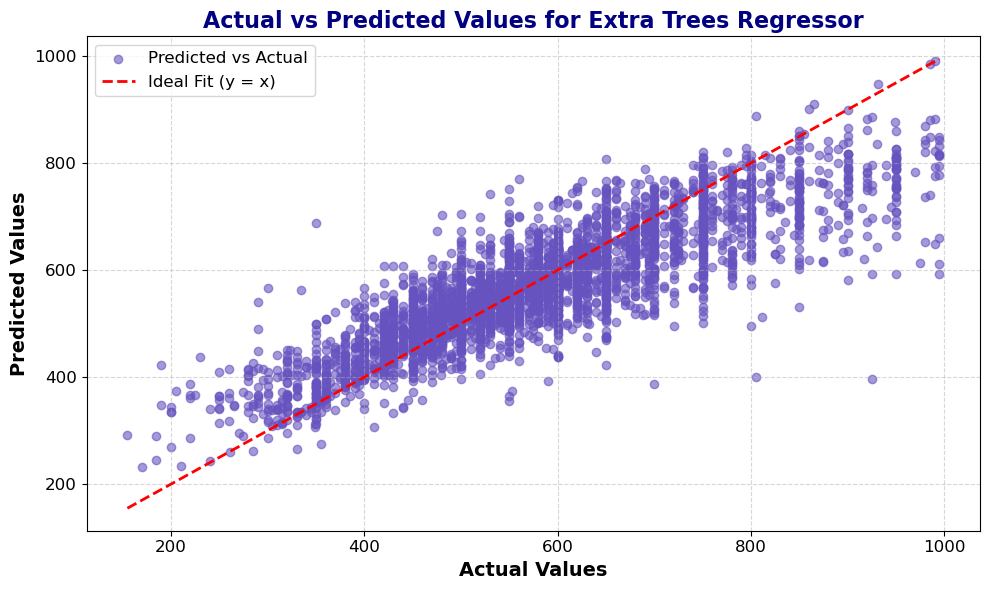

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Regressor:
  Training RMSE: 29.46, R^2: 0.96
  Test RMSE: 78.87, R^2: 0.71


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


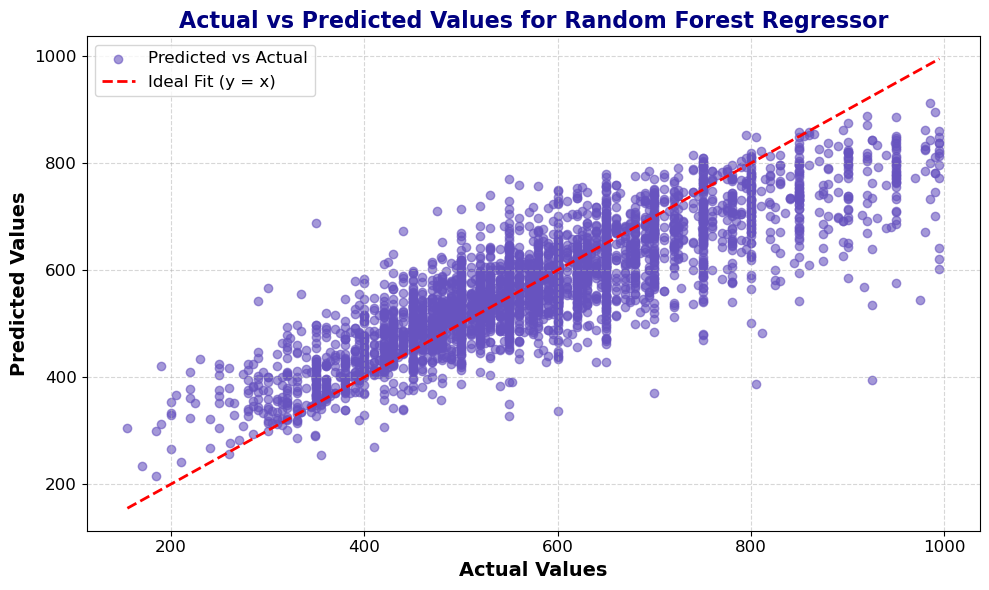

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost Regressor:
  Training RMSE: 104.88, R^2: 0.48
  Test RMSE: 108.44, R^2: 0.45


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


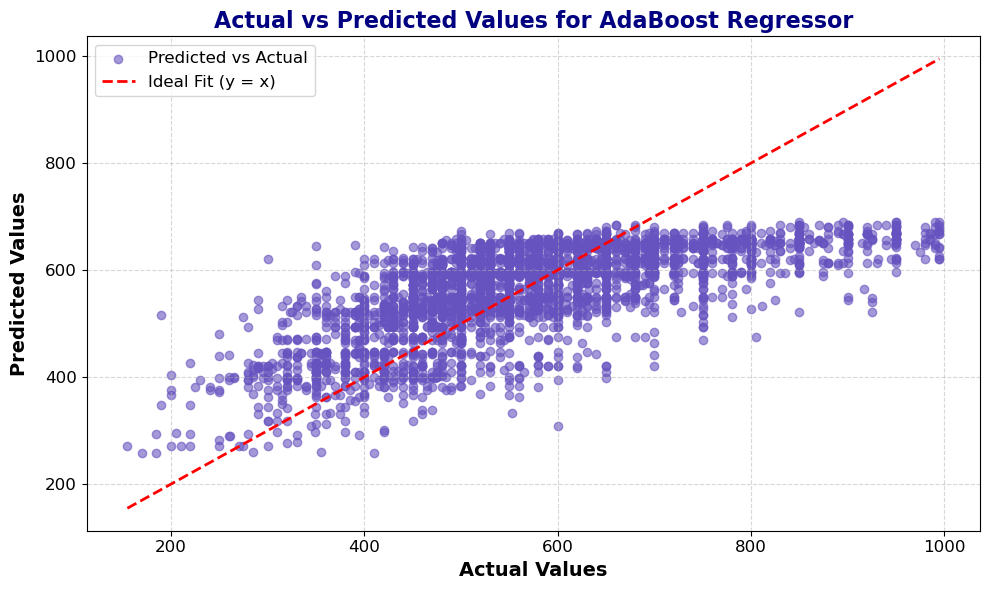

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Gradient Boosting Regressor:
  Training RMSE: 70.31, R^2: 0.77
  Test RMSE: 79.45, R^2: 0.70


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


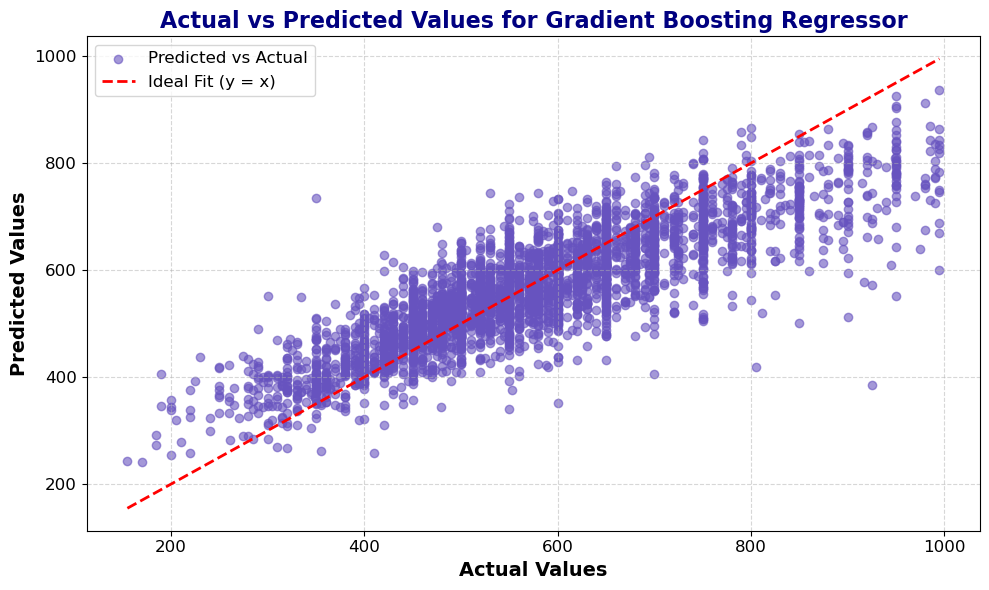

XGBoost Regressor:
  Training RMSE: 36.54, R^2: 0.94
  Test RMSE: 64.52, R^2: 0.80


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


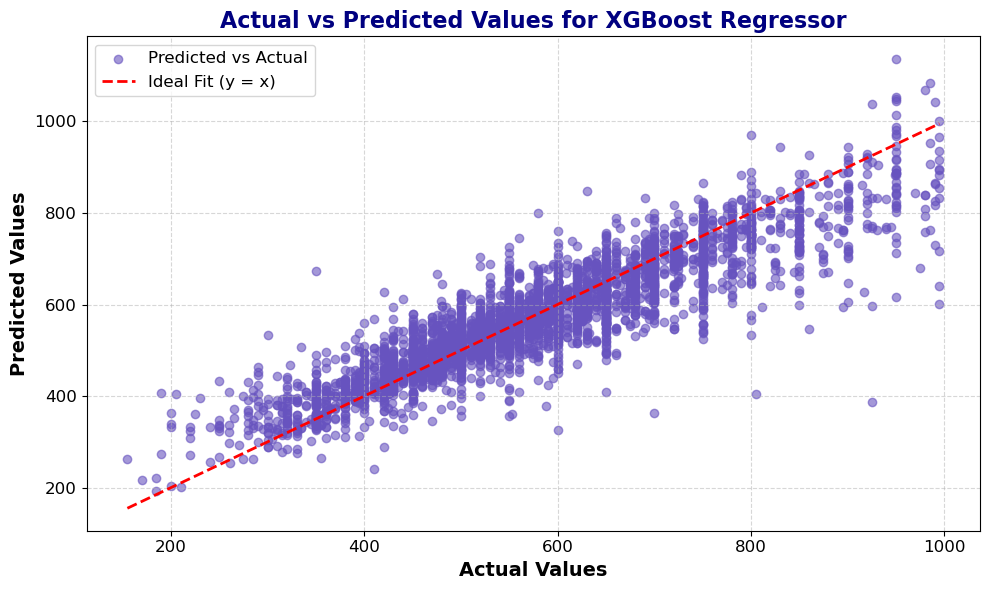

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Lasso Regression:
  Training RMSE: 96.69, R^2: 0.56
  Test RMSE: 92.96, R^2: 0.59


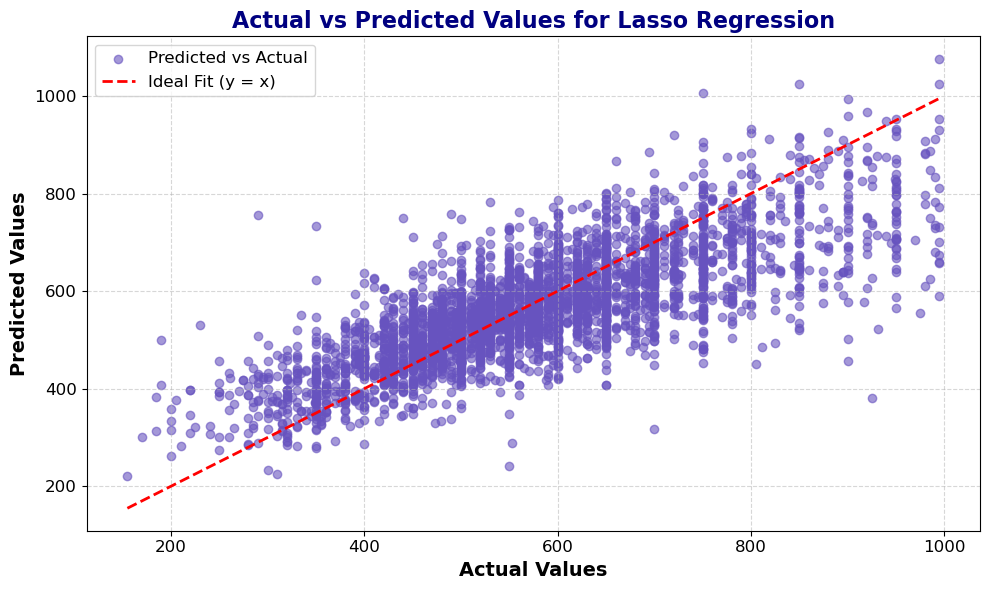

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge Regression:
  Training RMSE: 96.67, R^2: 0.56
  Test RMSE: 92.96, R^2: 0.59


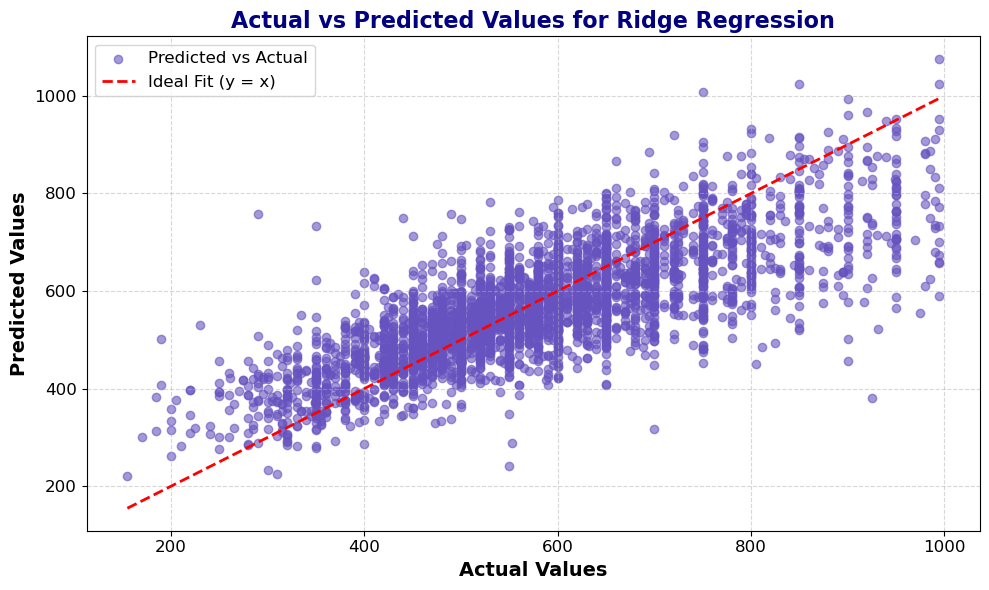

In [43]:
for model, name in models:
    model.fit(X_train, y_train)
    evaluate_and_plot(model, X_train, y_train, X_test, y_test, name)


## **3. Stacking Regressor**

In this section, a **Stacking Regressor** is used to combine multiple base models to improve predictive performance. Stacking is an ensemble learning technique where several different models (base learners) are trained, and their predictions are combined using a meta-learner (or final estimator). The meta-learner is trained on the outputs of the base models, learning to optimally weigh the contributions of each model.

### **Base Learners**:
- **Extra Trees Regressor**: An ensemble of unpruned decision trees that uses random splits for better generalization.
- **Support Vector Regressor (SVR)**: A model that uses kernel functions to capture non-linear relationships in the data.
- **XGBoost Regressor**: A highly efficient boosting model that builds sequential models to reduce errors from previous iterations.

### **Meta-Learner**:
- **Linear Regression**: The final estimator that combines the predictions from the base learners. It learns how to best combine the outputs of the base models for the final prediction.

By stacking multiple models, the aim is to improve prediction accuracy by leveraging the strengths of each individual model, resulting in a more robust rent price prediction model.

In [29]:
base_learners = [
    ('rf', ExtraTreesRegressor()),
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.01)),
    ('gbr', XGBRegressor(objective='reg:squarederror', 
    n_estimators=120,             
    learning_rate=0.15,           
    max_depth=5,                  
    random_state=42  )),
    # ('lasso', Lasso(alpha = 0.00001))
]

meta_learner = LinearRegression()
stack_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)

stack_regressor.fit(X_train, y_train)

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingRegressor(estimators=[('rf', ExtraTreesRegressor()),
                              ('svr', SVR(epsilon=0.01)),
                              ('gbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            import...None,
                                            interaction_constraints=None,
                                            learning_rate=0.15, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=120, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=LinearRegression())

Stacking Regressor:
  Training RMSE: 31.99, R^2: 0.95
  Test RMSE: 50.09, R^2: 0.88


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


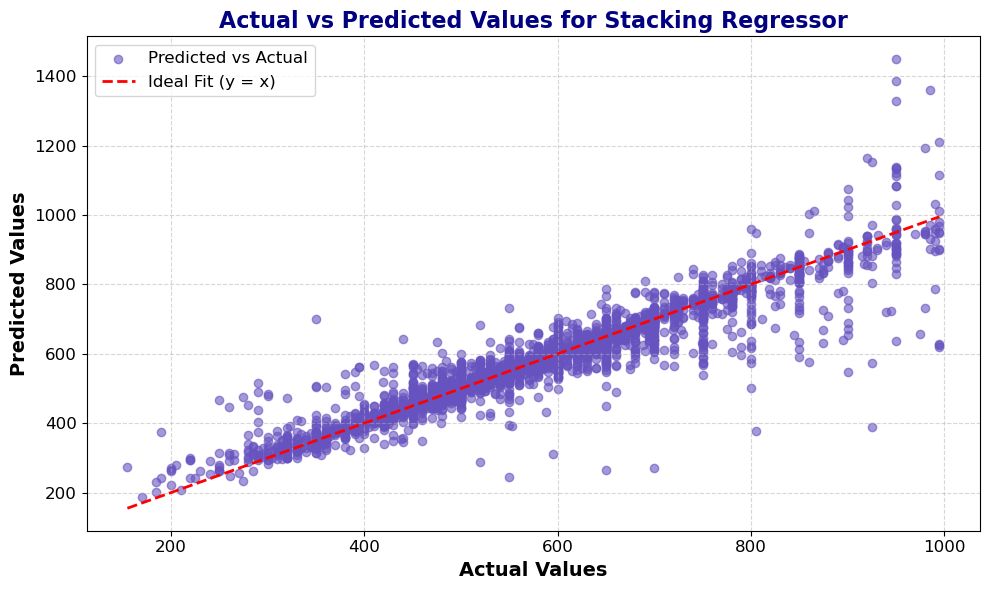

In [30]:
evaluate_and_plot(stack_regressor, X_train, y_train, X_test, y_test, "Stacking Regressor")

## **4. Deep Learning: Neural Network**

In this section, a deep neural network (DNN) is implemented to predict rent prices. Deep learning models are powerful in capturing complex patterns and non-linear relationships in the data, making them well-suited for this task. The architecture of the neural network consists of multiple layers with ReLU (Rectified Linear Unit) activations, allowing the model to learn hierarchical representations of the input features.

### **Neural Network Architecture**:
- **Input Layer**: Accepts the features from the dataset.
- **Hidden Layers**: Four fully connected layers with 128, 256, 256, and 256 neurons respectively. Each layer uses the ReLU activation function to introduce non-linearity, helping the model capture complex patterns in the data.
- **Output Layer**: A single neuron that outputs the predicted rent price.

### **Training Process**:
- **Loss Function**: The network uses **Mean Absolute Error (MAE)** as the loss function to minimize the difference between predicted and actual rent prices.
- **Optimizer**: **Adam optimizer** is used to update the weights during backpropagation, providing an adaptive learning rate for faster convergence.
- **Early Stopping**: The model implements early stopping to prevent overfitting by monitoring the validation loss. If the model does not improve after a certain number of epochs (patience), training is stopped early.

In [31]:
# Neural Network definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        # Define the first fully connected layer with 128 neurons
        self.layer1 = nn.Linear(input_dim, 128)
        # Define the second fully connected layer with 256 neurons
        self.layer2 = nn.Linear(128, 256)
        # Define the third fully connected layer with 256 neurons
        self.layer3 = nn.Linear(256, 256)
        # Define the fourth fully connected layer with 256 neurons
        self.layer4 = nn.Linear(256, 256)
        # Define the output layer with 1 neuron (predicting rent price)
        self.output_layer = nn.Linear(256, 1)

    def forward(self, x):
        # Apply ReLU activation after the first layer
        x = torch.relu(self.layer1(x))
        # Apply ReLU activation after the second layer
        x = torch.relu(self.layer2(x))
        # Apply ReLU activation after the third layer
        x = torch.relu(self.layer3(x))
        # Apply ReLU activation after the fourth layer
        x = torch.relu(self.layer4(x))
        # Output layer (no activation function, as it's a regression task)
        x = self.output_layer(x)
        return x

# Get the number of input features from the training set
input_dim = X_train.shape[1]

# Initialize the neural network with the input dimension
model = NeuralNetwork(input_dim)
print(model)

# Define the loss function (L1 Loss or Mean Absolute Error) for regression
criterion = nn.L1Loss()  

# Define the Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)  

# Convert the training and test sets into PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)  # Convert features to tensor
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Convert targets to tensor and reshape
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)  # Convert test features to tensor
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  # Convert test targets to tensor and reshape

# Create a TensorDataset to handle both inputs and targets for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader for mini-batch training (batch size of 32, shuffle the data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


NeuralNetwork(
  (layer1): Linear(in_features=90, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)


In [32]:
num_epochs = 50  # Number of epochs to train

best_loss = float('inf')  # Initialize best loss for early stopping
patience, trials = 10, 0  # Early stopping criteria

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation step for early stopping
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_tensor), y_test_tensor).item()

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(torch.load('best_model.pt'))
            break


Epoch 1/50, Loss: 0.7063
Epoch 2/50, Loss: 0.1782
Epoch 3/50, Loss: 0.1471
Epoch 4/50, Loss: 0.1357
Epoch 5/50, Loss: 0.1158
Epoch 6/50, Loss: 0.1066
Epoch 7/50, Loss: 0.0939
Epoch 8/50, Loss: 0.0865
Epoch 9/50, Loss: 0.0889
Epoch 10/50, Loss: 0.0784
Epoch 11/50, Loss: 0.0777
Epoch 12/50, Loss: 0.0779
Epoch 13/50, Loss: 0.0733
Epoch 14/50, Loss: 0.0677
Epoch 15/50, Loss: 0.0691
Epoch 16/50, Loss: 0.0710
Epoch 17/50, Loss: 0.0638
Epoch 18/50, Loss: 0.0683
Epoch 19/50, Loss: 0.0677
Epoch 20/50, Loss: 0.0584
Epoch 21/50, Loss: 0.0591
Epoch 22/50, Loss: 0.0569
Epoch 23/50, Loss: 0.0597
Epoch 24/50, Loss: 0.0511
Epoch 25/50, Loss: 0.0490
Epoch 26/50, Loss: 0.0533
Epoch 27/50, Loss: 0.0565
Epoch 28/50, Loss: 0.0550
Epoch 29/50, Loss: 0.0532
Epoch 30/50, Loss: 0.0514
Epoch 31/50, Loss: 0.0514
Epoch 32/50, Loss: 0.0589
Epoch 33/50, Loss: 0.0486
Epoch 34/50, Loss: 0.0459
Epoch 35/50, Loss: 0.0480
Early stopping at epoch 35


In [33]:
model.eval()  
with torch.no_grad():  
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")

y_pred_test_numpy = y_pred_test.numpy()  
y_pred_test_original_scale = np.expm1(y_pred_test_numpy)

y_test_numpy = y_test_tensor.numpy()
y_test_original_scale = np.expm1(y_test_numpy)

for actual, predicted in zip(y_pred_test_original_scale[:10], y_test_original_scale[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")



Test Loss: 0.0421
Actual: [558.0842], Predicted: [549.99994]
Actual: [536.8435], Predicted: [540.00006]
Actual: [614.0261], Predicted: [599.99994]
Actual: [34.878387], Predicted: [900.0001]
Actual: [465.02374], Predicted: [460.]
Actual: [676.1397], Predicted: [660.00006]
Actual: [611.8262], Predicted: [845.0001]
Actual: [474.898], Predicted: [500.00003]
Actual: [656.29626], Predicted: [649.9999]
Actual: [533.6419], Predicted: [514.99994]


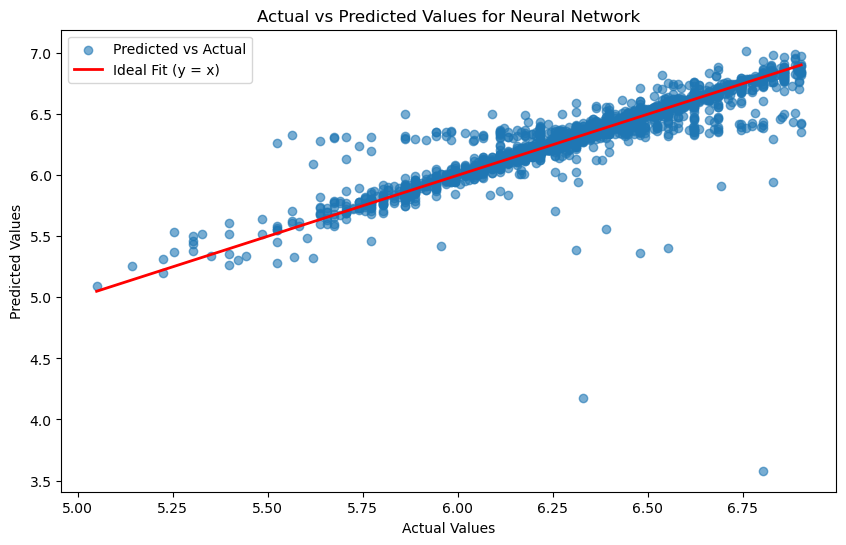

RMSE: 50.4059
R^2: 0.8805


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
y_pred_test_numpy = y_pred_test.numpy()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_numpy, alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='-', linewidth=2, label='Ideal Fit (y = x)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Neural Network')
plt.legend()
plt.savefig("../plots/DNN_performance.png")
plt.show()

rmse = mean_squared_error(y_test_original_scale, y_pred_test_original_scale, squared=False)
r2 = r2_score(y_test_original_scale, y_pred_test_original_scale)
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

## **5. Tabular Transformer Model**

In this section, a **Tabular Transformer Model** is implemented to predict rent prices. The transformer architecture, initially designed for natural language processing tasks, is adapted here for tabular data. Transformers excel at capturing complex dependencies and interactions between features, making them suitable for tasks where relationships between variables may not be strictly linear or simple.

### **Model Architecture**:
- **Input Layer**: Accepts tabular data features as input.
- **Transformer Encoder**: Multiple layers of Transformer encoders, each consisting of self-attention mechanisms and feed-forward layers. The attention mechanism enables the model to focus on relevant features and interactions dynamically.
- **Output Layer**: Produces a single output for the predicted rent price.

### **Transformer Details**:
- **Multi-Head Attention**: The transformer uses multi-head attention to learn feature dependencies by focusing on different aspects of the input features in parallel. This allows the model to capture complex relationships between features.
- **Positional Encoding**: Since transformers were initially designed for sequential data, they usually rely on positional encodings to understand the order of inputs. For tabular data, this can be ignored or adapted as needed.
- **Fully Connected Layers**: After the attention mechanism, the model passes through several fully connected layers for further processing before outputting the prediction.

### **Training Process**:
- **Loss Function**: The model uses **Mean Absolute Error (MAE)** to minimize the difference between the predicted and actual rent prices.
- **Optimizer**: **AdamW optimizer** is used, providing weight decay to prevent overfitting.
- **Learning Rate Scheduler**: A learning rate scheduler is applied to reduce the learning rate when the validation loss plateaus, helping the model converge more efficiently.


In [35]:
class TabTransformer(nn.Module):
    def __init__(self, input_dim, n_heads=8, n_layers=2, dropout=0.1):
        super(TabTransformer, self).__init__()
        self.input_layer = nn.Linear(input_dim, 128)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=128, nhead=n_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=n_layers)
        
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.input_layer(x)
        # (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        # Aggregate over sequence length dimension (if seq_len > 1)
        x = x.mean(dim=1)
        x = self.output_layer(x)
        return x

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = X_train.shape[1]
model = TabTransformer(input_dim)
print(model)

#loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training params
num_epochs = 50
best_loss = float('inf')
patience, trials = 10, 0

# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor).item()
    print(f"Validation Loss: {val_loss:.4f}")

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping (avoid overfitting)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(torch.load('best_model.pt'))
            break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
with torch.no_grad():
    final_predictions = model(X_test_tensor)

TabTransformer(
  (input_layer): Linear(in_features=90, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 1/50, Loss: 0.1782
Validation Loss: 0.1102
Epoch 2/50, Loss: 0.0972
Validation Loss: 0.1810
Epoch 3/50, Loss: 0.0764
Validation Loss: 0.1094
Epoch 4/50, Loss: 0.0731
Validation Loss: 0.1637
Epoch 5/50, Loss: 0.0686
Validation Loss: 0.1248
Epoch 6/50, Loss: 0.0662
Validation Loss: 0.1992
Epoch 7/50, Loss: 0.0647
Validation Loss: 0.1461
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/50, Loss: 0.0490
Validation Loss: 0.1030
Epoch 9/50, Loss: 0.0449
Validation Loss: 0.1216
Epoch 10/50, Loss: 0.0442
Validation Loss: 0.1153
Epoch 11/50, Loss: 0.0437
Validation Loss: 0.1056
Epoch 12/50, Loss: 0.0434
Validation Loss: 0.1137
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
Epoch 13/50, Loss: 0.0408
Validation Loss: 0.1128
Epoch 14/50, Loss: 0.0409
Validation Loss: 0.1103
Epoch 15/50, Loss: 0.0405
Validation Loss: 0.1115
Epoch 16/50, Loss: 0.0407
Validation Loss: 0.1073
Epoch 00016: reducing learning rate of group 0 to 1.0000e-06.
Epoch 17/50, Loss: 0.04

RMSE: 75.8790
R^2: 0.7293


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


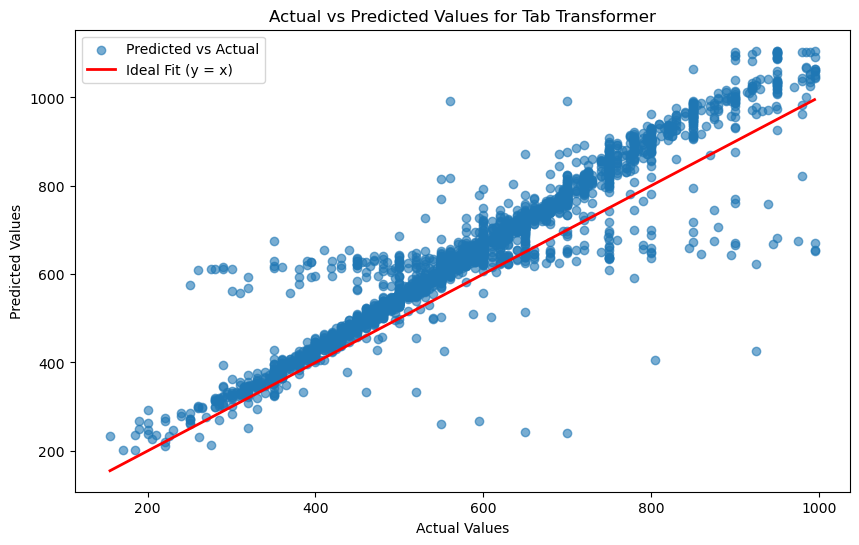

In [36]:
final_predictions_inv  = np.expm1(final_predictions)
rmse = mean_squared_error(y_test_original_scale, final_predictions_inv, squared=False)
r2 = r2_score(y_test_original_scale, final_predictions_inv)
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original_scale, final_predictions_inv, alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test_original_scale.min(), y_test_original_scale.max()], [y_test_original_scale.min(), y_test_original_scale.max()], color='red', linestyle='-', linewidth=2, label='Ideal Fit (y = x)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Tab Transformer')
plt.legend()
plt.savefig("../plots/TabTransformer_performance.png")
plt.show()


## **6. SHAP for Explainability**

In this section, **SHAP (SHapley Additive exPlanations)** is used to explain the predictions made by the machine learning models. SHAP values provide insights into how each feature influences the model's output, offering both global and local interpretability. Understanding feature importance helps identify which factors most strongly affect rent price predictions.

### **Key Visualizations**:
- **SHAP Summary Plot**: Displays the overall importance of each feature, where the horizontal axis shows the impact on model output, and each dot represents a specific data point.
  - **Red dots**: Indicate a high feature value for that instance, while **blue dots** represent a low feature value.
  - The position along the x-axis shows whether the feature pushes the prediction higher or lower.
  
- **SHAP Dependence Plot**: Illustrates the relationship between a feature and the model’s output, revealing interactions between features. It shows how changes in the value of one feature affect predictions.

 98%|===================| 8432/8611 [00:26<00:00]        

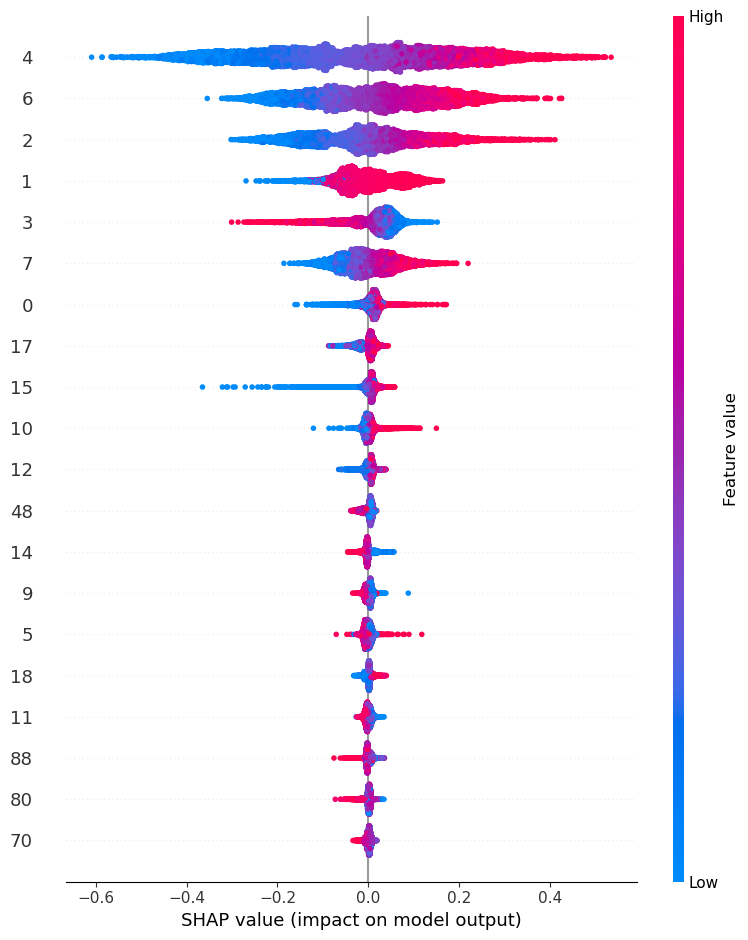

<Figure size 640x480 with 0 Axes>

In [37]:
# Initialize the SHAP explainer using an XGBoost model trained on the training data
explainer = shap.Explainer(XGBRegressor().fit(X_train, y_train), X_train)

# Compute SHAP values for the training dataset
shap_values = explainer(X_train)

# Generate the SHAP summary plot, which shows the impact of each feature on the model's output
summary_plots = shap.summary_plot(shap_values, X_train)

plt.savefig("../plots/SHAPplots.png")
plt.show()
